In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load data

In [2]:
# filename = 'Datasets/final_imit_spec.pkl'
# filename = 'Datasets/final_imit_spec2_128.pkl'
filename = 'Datasets/revision_imit_mti_spec2_128_last.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_train_images, imit_test_images, imit_y_train, imit_y_test, imit_env_train, imit_env_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_train_images.shape)
print(imit_test_images.shape)
print(imit_y_train.shape)
print(imit_y_test.shape)
print(imit_env_train.shape)
print(imit_env_test.shape)

(800, 120, 128, 128, 3)
(200, 120, 128, 128, 3)
(800, 120, 19)
(200, 120, 19)
(800,)
(200,)


In [3]:
filename = 'Datasets/revision_mti_mask_imit.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
mask_train_raw, mask_test_raw = [x[0], x[1]]
print(mask_train_raw.shape)
print(mask_test_raw.shape)

(800, 1482)
(200, 1482)


In [4]:
def dbd(mask_raw,threshold,fill_gap): # dynamic boundary detection
    mask = mask_raw > threshold 
    
    for i in range(mask.shape[0]):
        cnt = 1
        for j in range(1,mask.shape[1]):
            if mask[i,j-1] == False and mask[i,j] == False:
                cnt += 1
                continue
            if mask[i,j-1] == False and mask[i,j] == True:
                if cnt < fill_gap:
                    mask[i,j-cnt:j] = True
                cnt = 1
            if mask[i,j-1] == True:
                cnt = 1
    return mask

In [5]:
threshold = 61 # 50
fill_gap = 100 # 100
mask_train_dbd = dbd(mask_train_raw,threshold,fill_gap)
mask_test_dbd = dbd(mask_test_raw,threshold,fill_gap)

In [6]:
def sta_lta_v3(vec,nlta,nsta,stop_th,len_fix,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
#     state = 0 # '0' nothing, '1' signing
    stoppt = 0
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
#             if state == 1:
#                 stoppt = len(vec)-2
#                 vec2[stoppt-len_fix:stoppt] = vec[stoppt-len_fix:stoppt]
#                 mask[stoppt-len_fix:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
#         if i < nlta and np.mean(longwin) > 150:
#             vec2[0:i+nsta] = vec[0:i+nsta]
#             mask[0:i+nsta] = 1
#         if init_th < sum(shortwin)/sum(longwin):
#             if state == 0:
#                 startpt = i+nlta
#                 state = 1
#             if state == 1:
#                 continue
        
#         else:
#             if state == 0:
#                 continue
#             if state == 1:
        if sum(shortwin)/sum(longwin) > stop_th:
            continue
        else:
            if i+nlta+int(nsta/2) - stoppt < 25:
                stoppt = i+nlta+int(nsta/2)
                continue
            stoppt = i+nlta+int(nsta/2)
#             state = 0
            vec2[stoppt-len_fix:stoppt] = vec[stoppt-len_fix:stoppt]
            mask[stoppt-len_fix:stoppt] = 1
                    
    return vec2, mask

In [7]:
duration = 24.2
nsta_sec = 0.7
ratio = imit_env_train[0].shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,imit_env_train[0].shape[-1])
idx = 27
# init_th = 0.6
len_fix = int(2.3*ratio)
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(imit_env_train)):
    vecs_train.append(sta_lta_v3(imit_env_train[i],nlta,nsta,stop_th,len_fix,stepsz)[0])
    mask_train.append(sta_lta_v3(imit_env_train[i],nlta,nsta,stop_th,len_fix,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(imit_env_test)):
    vecs_test.append(sta_lta_v3(imit_env_test[i],nlta,nsta,stop_th,len_fix,stepsz)[0])
    mask_test.append(sta_lta_v3(imit_env_test[i],nlta,nsta,stop_th,len_fix,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train_fix = np.array(mask_train)
mask_test_fix = np.array(mask_test)

In [8]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [9]:
duration = 24.2
nsta_sec = 0.7
ratio = imit_env_train[0].shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,imit_env_train[0].shape[-1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(imit_env_train)):
    vecs_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(imit_env_test)):
    vecs_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train_orig = np.array(mask_train)
mask_test_orig = np.array(mask_test)

In [10]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [11]:
def down_mask(mask, des_len):
    return np.array([mask[int(len(mask)/des_len*i)] for i in range(des_len)])

In [13]:
num_class = 19

In [22]:
des_len = imit_train_images.shape[1]
mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train_dbd])
mask_down_test = np.array([down_mask(mask, des_len) for mask in mask_test_dbd])
y_down_train = np.array([down_mask(y, des_len) for y in imit_y_train])
y_down_test = np.array([down_mask(y, des_len) for y in imit_y_test])
y_down_train_cat = to_categorical(y_down_train, num_classes=num_class)
y_down_test_cat = to_categorical(y_down_test, num_classes=num_class)
print(mask_down_train.shape)
print(mask_down_test.shape)
print(y_down_train.shape)
print(y_down_test.shape)
print(y_down_train_cat.shape)
print(y_down_test_cat.shape)

(800, 120)
(200, 120)
(800, 120, 19)
(200, 120, 19)
(800, 120, 19, 19)
(200, 120, 19, 19)


In [23]:
print(mask_down_train.shape)
mask_y = np.argmax(y_down_train,-1) == 0
print(mask_y.shape)
cmp = mask_y != mask_down_train
print(cmp.shape)
acc = np.sum(cmp)/(cmp.shape[0]*cmp.shape[1])*100
print(acc)

(800, 120)
(800, 120)
(800, 120)
84.17916666666667


In [24]:
thresholds = np.linspace(1,255,255)
acc_ls_dbd = []
for j,v in enumerate(thresholds):
    mask_train = dbd(mask_train_raw,v,fill_gap)
    mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
    cmp = mask_y != mask_down_train
    acc = np.sum(cmp)/(cmp.shape[0]*cmp.shape[1])*100
    acc_ls_dbd.append(acc)
    print(j+1,'. Threshold:',thresholds[j],', acc:',acc)

1 . Threshold: 1.0 , acc: 67.49062500000001
2 . Threshold: 2.0 , acc: 67.49062500000001
3 . Threshold: 3.0 , acc: 67.49062500000001
4 . Threshold: 4.0 , acc: 67.49062500000001
5 . Threshold: 5.0 , acc: 67.49062500000001
6 . Threshold: 6.0 , acc: 67.49062500000001
7 . Threshold: 7.0 , acc: 67.49062500000001
8 . Threshold: 8.0 , acc: 67.49062500000001
9 . Threshold: 9.0 , acc: 67.49062500000001
10 . Threshold: 10.0 , acc: 67.49062500000001
11 . Threshold: 11.0 , acc: 67.49062500000001
12 . Threshold: 12.0 , acc: 67.49062500000001
13 . Threshold: 13.0 , acc: 67.49062500000001
14 . Threshold: 14.0 , acc: 67.49062500000001
15 . Threshold: 15.0 , acc: 67.49062500000001
16 . Threshold: 16.0 , acc: 67.49062500000001
17 . Threshold: 17.0 , acc: 67.49062500000001
18 . Threshold: 18.0 , acc: 67.49062500000001
19 . Threshold: 19.0 , acc: 67.49062500000001
20 . Threshold: 20.0 , acc: 67.49062500000001
21 . Threshold: 21.0 , acc: 67.49062500000001
22 . Threshold: 22.0 , acc: 67.49062500000001
23 . T

183 . Threshold: 183.0 , acc: 55.541666666666664
184 . Threshold: 184.0 , acc: 55.37083333333334
185 . Threshold: 185.0 , acc: 55.12708333333334
186 . Threshold: 186.0 , acc: 54.85729166666666
187 . Threshold: 187.0 , acc: 54.619791666666664
188 . Threshold: 188.0 , acc: 54.40833333333334
189 . Threshold: 189.0 , acc: 54.12916666666666
190 . Threshold: 190.0 , acc: 53.86666666666666
191 . Threshold: 191.0 , acc: 53.596875
192 . Threshold: 192.0 , acc: 53.35520833333334
193 . Threshold: 193.0 , acc: 53.10729166666667
194 . Threshold: 194.0 , acc: 52.802083333333336
195 . Threshold: 195.0 , acc: 52.48645833333333
196 . Threshold: 196.0 , acc: 52.20312499999999
197 . Threshold: 197.0 , acc: 51.92187499999999
198 . Threshold: 198.0 , acc: 51.648958333333326
199 . Threshold: 199.0 , acc: 51.33958333333334
200 . Threshold: 200.0 , acc: 50.971875
201 . Threshold: 201.0 , acc: 50.64999999999999
202 . Threshold: 202.0 , acc: 50.31666666666666
203 . Threshold: 203.0 , acc: 50.026041666666664
204

In [25]:
# filename = 'Datasets/final_imit_spec.pkl'
# filename = 'Datasets/final_imit_spec2_128.pkl'
filename = 'Datasets/final_imit_spec2_128_last.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_train_images, imit_test_images, imit_y_train, imit_y_test, imit_env_train, imit_env_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_train_images.shape)
print(imit_test_images.shape)
print(imit_y_train.shape)
print(imit_y_test.shape)
print(imit_env_train.shape)
print(imit_env_test.shape)

(800, 120, 128, 128, 3)
(200, 120, 128, 128, 3)
(800, 120, 19)
(200, 120, 19)
(800,)
(200,)


In [26]:
des_len = imit_train_images.shape[1]
mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train_orig])
mask_down_test = np.array([down_mask(mask, des_len) for mask in mask_test_orig])
y_down_train = np.array([down_mask(y, des_len) for y in imit_y_train])
y_down_test = np.array([down_mask(y, des_len) for y in imit_y_test])
y_down_train_cat = to_categorical(y_down_train, num_classes=num_class)
y_down_test_cat = to_categorical(y_down_test, num_classes=num_class)
print(mask_down_train.shape)
print(mask_down_test.shape)
print(y_down_train.shape)
print(y_down_test.shape)
print(y_down_train_cat.shape)
print(y_down_test_cat.shape)

(800, 120)
(200, 120)
(800, 120, 19)
(200, 120, 19)
(800, 120, 19, 19)
(200, 120, 19, 19)


In [27]:
print(mask_down_train.shape)
mask_y = np.argmax(y_down_train,-1) == 0
print(mask_y.shape)
cmp = mask_y != mask_down_train
print(cmp.shape)
acc = np.sum(cmp)/(cmp.shape[0]*cmp.shape[1])*100
print(acc)

(800, 120)
(800, 120)
(800, 120)
83.53125


In [28]:
win_sizes = np.linspace(0.1,3,30)
len_fix_win = win_sizes*ratio
acc_ls_fix = []
for j,v in enumerate(len_fix_win):
    mask_train = []
    for i in range(len(imit_env_train)):
        mask_train.append(sta_lta_v3(imit_env_train[i],nlta,nsta,stop_th,int(v),stepsz)[1])
    mask_train = np.array(mask_train)
    mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
    cmp = mask_y != mask_down_train
    acc = np.sum(cmp)/(cmp.shape[0]*cmp.shape[1])*100
    acc_ls_fix.append(acc)
    print(j+1,'. Win size:',win_sizes[j],', acc:',acc)

1 . Win size: 0.1 , acc: 33.31458333333333
2 . Win size: 0.2 , acc: 34.10729166666667
3 . Win size: 0.3 , acc: 35.959375
4 . Win size: 0.4 , acc: 37.90104166666667
5 . Win size: 0.5 , acc: 40.338541666666664
6 . Win size: 0.6 , acc: 42.58645833333333
7 . Win size: 0.7 , acc: 45.030208333333334
8 . Win size: 0.7999999999999999 , acc: 47.35208333333333
9 . Win size: 0.8999999999999999 , acc: 50.478125
10 . Win size: 0.9999999999999999 , acc: 52.661458333333336
11 . Win size: 1.0999999999999999 , acc: 55.19270833333333
12 . Win size: 1.2 , acc: 57.384375
13 . Win size: 1.3 , acc: 59.75729166666667
14 . Win size: 1.4 , acc: 61.98229166666667
15 . Win size: 1.5 , acc: 64.13854166666667
16 . Win size: 1.5999999999999999 , acc: 66.37708333333333
17 . Win size: 1.7 , acc: 68.99791666666667
18 . Win size: 1.8 , acc: 70.696875
19 . Win size: 1.9 , acc: 72.40625
20 . Win size: 2.0 , acc: 73.6875
21 . Win size: 2.0999999999999996 , acc: 74.73333333333333
22 . Win size: 2.1999999999999997 , acc: 75

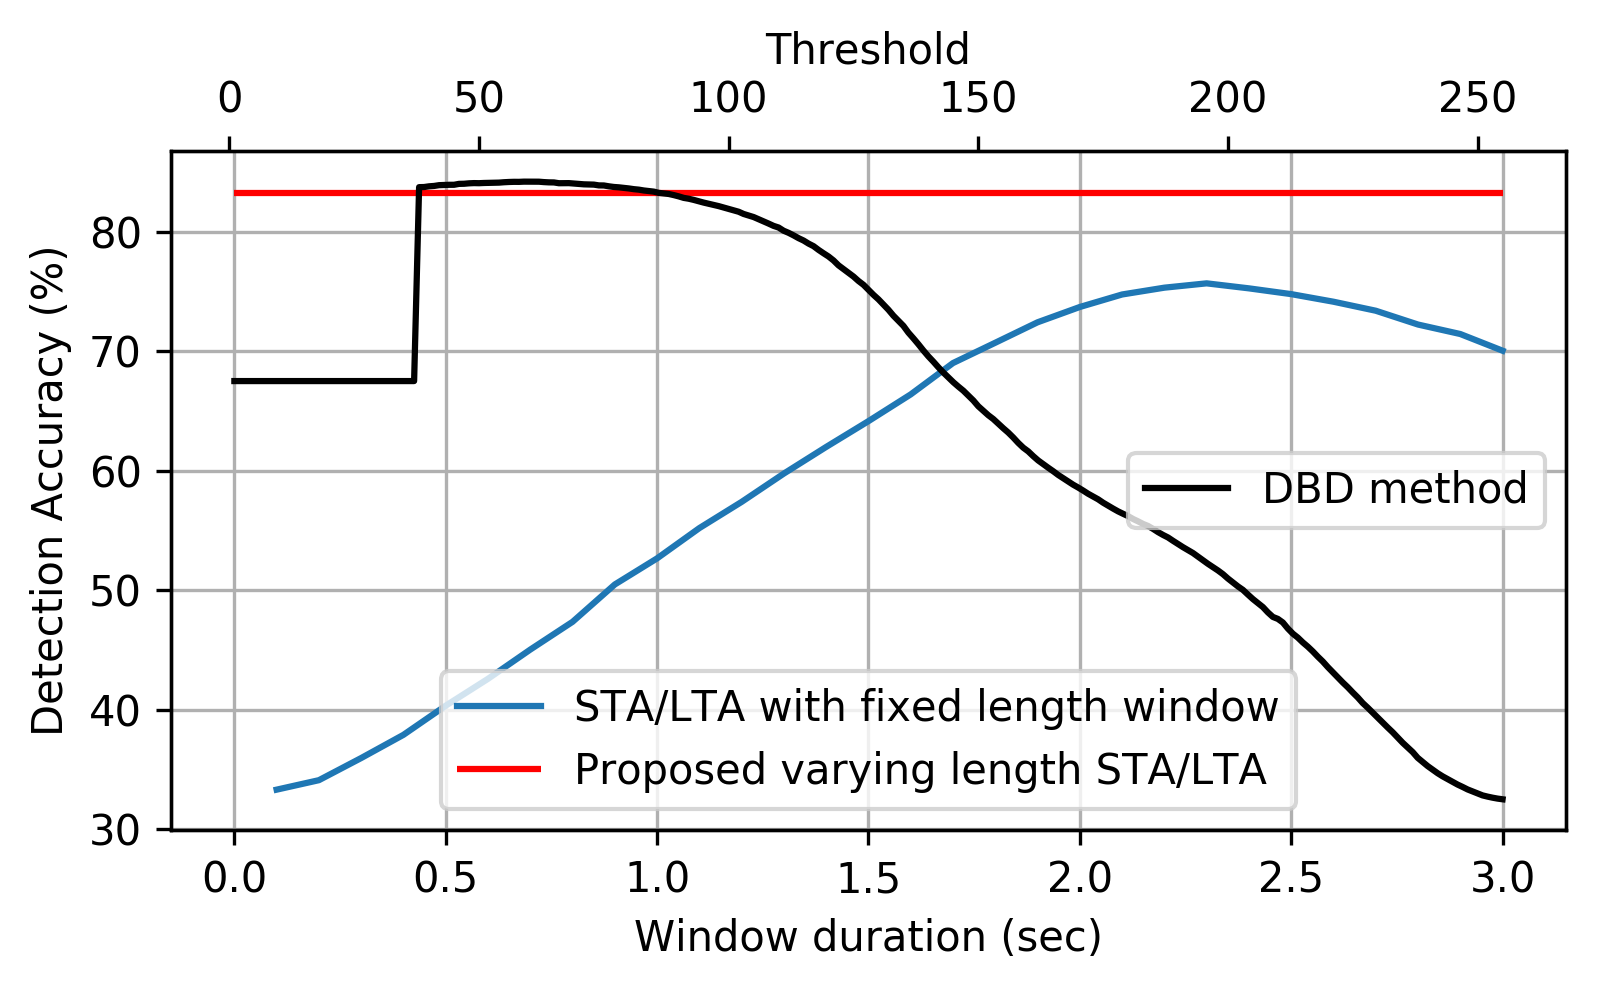

In [50]:
fig = plt.figure(figsize=(6,3),dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(win_sizes,acc_ls_fix,label='STA/LTA with fixed length window')
ax1.set_xlabel('Window duration (sec)')
ax1.set_ylabel('Detection Accuracy (%)')
ax1.grid('on')
ax1.hlines(83.2,0,win_sizes[-1],'r',label='Proposed varying length STA/LTA')
ax1.legend(loc='lower center')
ax2.plot(thresholds,acc_ls_dbd,'k',label='DBD method')
ax2.set_xlabel('Threshold')
ax2.legend(loc='center right')
fig.show()
fig.savefig('results/3 motion detector compare.png',bbox_inches='tight')